In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset Loading**

In [3]:
# Read the csv file into a DataFrame
# Specify the delimiter as tab ('\t')
dataset_1 = pd.read_csv("/content/drive/MyDrive/Bangla_Hate_Speech/Dataset_1/bengali_hate_v1.csv", delimiter='\t')

# Display the DataFrame after removing the 'Unnamed: 0' column
dataset_1.head()

,text,label
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical
4,পাকিস্তান আমার বাল,Geopolitical


In [45]:
# Display the count of each label
label_counts = dataset_1['label'].value_counts()
print("\nLabel counts:")
print(label_counts)


Label counts:
label
Geopolitical      1379
Personal           629
Political          592
Religious          502
Gender abusive     316
Name: count, dtype: int64


In [4]:
# Read the csv file into a DataFrame
dataset_2 = pd.read_csv("/content/drive/MyDrive/Bangla_Hate_Speech/Dataset_1/bengali_hate_v2.csv")

# Drop the 'Unnamed: 0' column
dataset_2.drop('target', axis=1, inplace=True)

# Display the DataFrame after removing the 'Unnamed: 0' column
dataset_2.head()

,text,label
0,বৌদির দুধ দেকে তো আমার ই চোখ ঠিক ছিলো না - পোল...,Personal
1,এই সরকার কে যারা নির্লজ্জের মত সাপোর্ট দিয়েছে ...,Political
2,পিলখানা হত্যাকান্ড বাংলাদেশের প্রতিরক্ষা ব্যবস...,Geopolitical
3,ভারতের অর্থনীতি নিয়ে আপনাদের ভাবতে হবে না। ভা...,Geopolitical
4,খানকির পুলা মালায়নদের মেরে সাফা করে ফেল,Personal


In [46]:
# Display the count of each label
label_counts = dataset_2['label'].value_counts()
print("\nLabel counts:")
print(label_counts)


Label counts:
label
Personal        2189
Geopolitical    1738
Religious        957
Political        814
Name: count, dtype: int64


In [5]:
# Merge the two datasets
merged_dataset = pd.concat([dataset_1, dataset_2], ignore_index=True)
# Extract unique labels
unique_labels = merged_dataset['label'].unique()

# Create a mapping from label strings to integers
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

# Apply this mapping to the dataset
merged_dataset['label'] = merged_dataset['label'].map(label_to_id)

In [6]:
# Print the mapping
print("Label to ID mapping:")
for label, idx in label_to_id.items():
    print(f"{label}: {idx}")

Label to ID mapping:
Geopolitical: 0
Religious: 1
Personal: 2
Gender abusive: 3
Political: 4


In [7]:
# Split the data into train, validation, and test sets with stratification to maintain label distribution
train_data, temp_data = train_test_split(merged_dataset, test_size=0.2, stratify=merged_dataset['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

In [8]:
# Display the shapes of the splits
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (7292, 2)
Validation set shape: (912, 2)
Test set shape: (912, 2)


In [9]:
label_counts = train_data['label'].value_counts()
label_counts

label
0    2493
2    2254
1    1167
4    1125
3     253
Name: count, dtype: int64

In [10]:
label_counts = test_data['label'].value_counts()
label_counts

label
0    312
2    282
1    146
4    141
3     31
Name: count, dtype: int64

In [11]:
label_counts = val_data['label'].value_counts()
label_counts

label
0    312
2    282
1    146
4    140
3     32
Name: count, dtype: int64

In [12]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 7292
Length of test dataset: 912
Length of validation dataset: 912


# **Custom Dataset Class**

In [25]:
class BanglaHateSpeechDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=150):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']

        inputs = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [14]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-qwgn73ai
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-qwgn73ai
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=b44f32d1a63821b0e574c9155ef0b03341fad0f75becbf5765c22630734ce8f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ngl3ibgh/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=93da8058f85325cf51c334fb407b4cf57e6099e

In [15]:
!pip install transformers[sentencepiece]

In [16]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [17]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.6 MB/s eta 0:00:00


# **mBERT model and its tokenizer**

In [85]:
# Model loading
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
num_classes = 5  #number of classes in our dataset

model_name = "google-bert/bert-base-multilingual-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [86]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# **Apply normalization to the datasets**

In [87]:
# Apply normalization to the datasets
train_data['text'] = train_data['text'].apply(normalize)
test_data['text'] = test_data['text'].apply(normalize)
val_data['text'] = val_data['text'].apply(normalize)

# **Custom dataset and dataloader**

In [88]:
# Define custom datasets
train_dataset = BanglaHateSpeechDataset(train_data, tokenizer)
val_dataset = BanglaHateSpeechDataset(val_data, tokenizer)
test_dataset = BanglaHateSpeechDataset(test_data, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# **Train Dataset Encoding Printing**

In [89]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,  18601,  77960,  39427,  16431,  17511,    979,  39994,  93565,
         28410,    971,  24758,    939,  77045,  32437,    963,  11199,    968,
         28725,  37422,  26109,    944,  29993,  66449,  12235,  45284,    972,
         16166,  15258, 108600,  16755,    948,  39427,  69514,  69145,  12079,
         13334,    965,  64437,  32437,  14339,    967,  27268, 111240,  15002,
        111236,  13458,  13334,  91599,    119,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      

# **Test Dataset Encoding Printing**

In [90]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,  12051,    955,  58354,  43004,    976,  12235,  47356,  11128,
         82937,  31527,    978,  15002, 111240,  65045,  13458,  11737,    948,
         11128,  69514, 103093,    102,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      

# **Validation Dataset Encoding Printing**

In [91]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,    971,  40102,  14112,  62853,    974,  54464,  39427,  16166,
         34070,  12079,    955,  16166, 111240, 111219,  13104,    117,    946,
         28410,  97717,    974,  54464,    953,  29484,  90425,    948,  12079,
         53574,  14339,  88324,  18243,  17660, 111219,  39427,  65383,  92576,
           974,  54464,    965,  41602,  53761,    920,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      

# **Train Dataset Decoding Printing**

In [92]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: তারেক জিয়ার জন্মদিন উপলক্ষে পোষ্টে কিছু লোক যারা আসলে দলকানা তারা যেভাষায় মন্তব্য দিচ্ছে তাতে বুঝা যায় এসকল লোক হয় আওয়ামী ঘরনার না হয় আবাল কারন একজন লোক কে চোর বলতে হলে প্রমান প্রোয়জন কিন্তু এরাকোন প্রমান ছারাই যা মনেহয় বলে যায় তারেক যদি চোর হত তাহলে এই আওয়ামী সরকার এত দিনে তাকে ফাসী নাদীলও কমকরে বছর এর সাজা দীয়ে ছেরে দিত
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0], device='cuda:0')
Label: 4


# **Test Dataset Decoding Printing**

In [93]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: এবং জামাত শিবির কে নিয়ে সম্মেলন করুক পাকিস্তান
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')
Label: 4


# **Validation Dataset Decoding Printing**

In [94]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: ভাই এই সরকার রক্তচুষা জু্ঁক, ওরা আরও রক্ত চায় এদের কাছ থেকে দেশকে বাঁচাতে হলে রক্ত দিতে হবে ।
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')
Label: 4


# **Optimizer and Loss Function**
## **Class Weighting:**
Use class weights to give more importance to the minority class during training. This can help the model to focus more on the minority class.

In [95]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

learning_rate = 2e-5
# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# **Training the model**

In [96]:
# Training loop
num_epochs = 1
gradient_accumulation_steps = 4  # Accumulate gradients over 4 steps

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average training loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    # Wrap val_loader with tqdm for progress bar
    for batch in tqdm(val_loader, desc=f'Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        _, predicted = torch.max(logits, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")

Epoch 1/1 - Average training loss: 0.9303


Epoch 1/1 - Validation Accuracy: 0.7434
Epoch 1 completed in 3m 15s


# **Testing the model**

In [97]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')
test_jaccard_score = jaccard_score(test_labels, test_preds, average='macro')
test_log_loss = log_loss(test_labels, test_probs)


Testing: 100%|██████████| 114/114 [00:07<00:00, 14.54it/s]


In [98]:
print(test_preds)
print(test_labels)

[4, 3, 2, 0, 4, 0, 0, 3, 4, 0, 4, 0, 3, 4, 0, 1, 0, 2, 4, 2, 4, 1, 1, 3, 4, 0, 2, 1, 1, 0, 4, 0, 3, 3, 1, 2, 0, 3, 0, 1, 1, 1, 4, 1, 0, 4, 0, 1, 2, 0, 3, 1, 0, 2, 0, 3, 0, 1, 0, 4, 0, 4, 0, 2, 0, 2, 3, 1, 1, 3, 2, 0, 2, 0, 0, 2, 1, 0, 1, 3, 0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 3, 2, 2, 1, 3, 3, 2, 2, 1, 4, 0, 2, 2, 0, 0, 2, 4, 0, 2, 2, 3, 0, 0, 4, 4, 1, 0, 2, 4, 4, 4, 2, 2, 3, 2, 2, 0, 1, 0, 4, 0, 4, 2, 4, 3, 4, 1, 3, 2, 0, 2, 2, 1, 0, 4, 2, 3, 1, 0, 4, 0, 1, 2, 3, 0, 0, 3, 3, 0, 2, 2, 3, 0, 0, 2, 0, 1, 1, 4, 1, 4, 0, 2, 0, 0, 1, 2, 1, 4, 2, 3, 0, 3, 4, 0, 2, 2, 0, 0, 2, 2, 2, 4, 2, 4, 4, 3, 0, 4, 1, 1, 1, 4, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 4, 0, 4, 0, 2, 0, 2, 0, 1, 4, 0, 0, 2, 1, 2, 1, 0, 2, 4, 4, 4, 4, 2, 0, 0, 2, 4, 1, 0, 3, 2, 0, 4, 4, 0, 0, 4, 4, 2, 2, 0, 3, 2, 4, 3, 1, 0, 0, 3, 1, 0, 0, 4, 2, 3, 0, 0, 2, 4, 0, 0, 2, 2, 2, 4, 1, 0, 4, 2, 3, 0, 0, 0, 2, 2, 1, 1, 0, 0, 4, 4, 0, 0, 1, 3, 1, 0, 3, 1, 3, 4, 0, 4, 2, 4, 2, 0, 0, 4, 1, 3, 0, 3, 0, 0, 3, 4, 3, 0, 1, 3, 1, 3, 0, 2, 

# **Printing the evaluation metric results**

In [99]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Jaccard Score: {test_jaccard_score}')
print(f'Log Loss: {test_log_loss}')

Test Accuracy: 0.7598684210526315
Test Precision: 0.7014285329325771
Test Recall: 0.7931875333136134
Test F1 Score: 0.7079267815752905
Test Jaccard Score: 0.5747566472759565
Log Loss: 0.6886536333299405


In [100]:
from sklearn.preprocessing import LabelBinarizer
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
test_labels_one_hot = label_binarizer.fit_transform(test_labels)

# Reshape the one-hot encoded labels
num_classes = len(label_binarizer.classes_)
test_labels_one_hot = test_labels_one_hot.reshape(-1, num_classes)

# Creating a 2D array for test_preds
num_samples = len(test_preds)
num_classes = len(label_binarizer.classes_)
formatted_preds = [[0] * num_classes for _ in range(num_samples)]
for i, pred in enumerate(test_preds):
    formatted_preds[i][pred] = 1

# Calculate ROC AUC score for multiclass classification
test_roc_auc_score = roc_auc_score(test_labels_one_hot, formatted_preds, average='macro', multi_class='ovo')
print("Test ROC AUC Score:", test_roc_auc_score)

Test ROC AUC Score: 0.8678135615004479


# **Classification Report**

In [101]:
# Mapping numeric labels to category names
label_map = {0: 'Geopolitical', 1: 'Religious', 2: 'Personal', 3: 'Gender abusive', 4:'Political'}

# Convert numeric predictions to label names
predicted_labels = [label_map[pred] for pred in test_preds]
true_labels = [label_map[label] for label in test_labels]

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
                precision    recall  f1-score   support

Gender abusive       0.25      0.84      0.39        31
  Geopolitical       0.95      0.81      0.88       312
      Personal       0.80      0.59      0.68       282
     Political       0.64      0.86      0.73       141
     Religious       0.86      0.87      0.86       146

      accuracy                           0.76       912
     macro avg       0.70      0.79      0.71       912
  weighted avg       0.82      0.76      0.77       912



# **Confusion Matrix of Bangla Fake News**

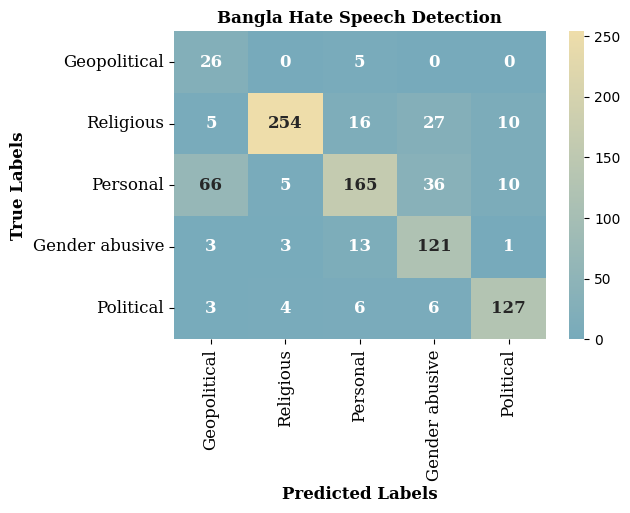

In [102]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette("blend:#7AB,#EDA", as_cmap=True)# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette, linecolor='white',\
                      xticklabels=['Geopolitical', 'Religious', 'Personal', 'Gender abusive', 'Political'], \
                      yticklabels=['Geopolitical', 'Religious', 'Personal', 'Gender abusive', 'Political'], \
                      annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Bangla Hate Speech Detection', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

plt.show()


# **Store predicted results to a csv file**

In [103]:
# Combine the lists into a DataFrame
data = {'Content': test_data['text'],
        'True_Labels': test_data['label'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('mBERT_predicted_results.csv', index=False)

# **save model, tokenizer, and classifier**

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json')


('/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json/vocab.txt',
 '/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json/added_tokens.json',
 '/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json/tokenizer.json')

# **load model, tokenizer, and classifier**

In [ ]:
# load the model
model.from_pretrained('/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json')


ElectraTokenizerFast(name_or_path='/content/drive/MyDrive/Bangla_Aggressive_Text/Bangla_Aggressive_Text_BanglaBERT/Bangla_Aggressive_Text_BanglaBERT_Tokenizer.json', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=Tr